# Initialise main directory


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls -ltra '{main_dir}'/.

Mounted at /content/gdrive
ls: '/content/gdrive/My Drive/UpworkNotebooks/Opera Files//./Audios': No such file or directory
total 32
lrw------- 1 root root    0 May  1 02:47 Audios -> /content/gdrive/.shortcut-targets-by-id/1DOvML8hO7v6XEq5-HQAQSvo7eKca7tSf/Audios
drwx------ 2 root root 4096 Sep 12 11:40 New_male_only_200_each
drwx------ 2 root root 4096 Sep 22 14:29 All_Data
drwx------ 2 root root 4096 Sep 22 14:40 Keras_Tuner_Logs
drwx------ 2 root root 4096 Sep 22 14:57 Documentation
drwx------ 2 root root 4096 Sep 22 15:02 Helper_Notebooks
drwx------ 2 root root 4096 Sep 22 15:03 Csv_Files
drwx------ 2 root root 4096 Sep 22 15:05 Main_Notebooks
drwx------ 2 root root 4096 Oct 27 13:51 CNN_Data


# Install and import libraries

In [2]:
!pip install -q librosa
!pip install -q tensorflow_io
!pip install -q pysoundfile
!pip install -q -U keras-tuner

     |████████████████████████████████| 22.7 MB 2.0 MB/s 
     |████████████████████████████████| 2.1 MB 52.2 MB/s 
     |████████████████████████████████| 97 kB 2.9 MB/s 


In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

import keras_tuner as kt
from ast import literal_eval

import os
import sys
import time

%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import librosa
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from PIL import Image
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, models, layers
from tensorflow import keras
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
import pickle
import joblib

# Data Processing-helper functions


In [4]:
def padding(array, des_height, des_width):
  """
  :param array: numpy array
  :param des_height: desired height
  :param des_width: desired width
  :return: padded array
  """
  height = array.shape[0]
  width = array.shape[1]
  a = max((des_height - height) // 2, 0)
  aa = max(des_height - a - height, 0)
  b = max((des_width - width) // 2, 0)
  bb = max(des_width - b - width,0)

  return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [12]:
def generate_features(y_cut):

  #max audio file feature width
  max_size=329
  sr = 28000
  
  #create features: stft, MFCCs, spec_centroid, spec_bw, chroma_stft
  # stft = padding(np.abs(librosa.stft(y_cut, n_fft=255, hop_length = 512)), 128, max_size)
  MFCCs = padding(librosa.feature.mfcc(y_cut,n_mfcc=128),128,max_size)
  # spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
  # chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
  # spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
  
  # #pad and append the spec_centroid, spec_bw

  # image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
  # image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
  
  # #repeat the padded spec_bw, spec_centroid and chroma stft until they are stft and MFCC-sized
  # for i in range(0,9):
  #     image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
  #     image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
  #     image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
  # image=np.dstack((image,np.abs(stft)))
  # image=np.dstack((image,MFCCs))
  image = MFCCs
  return image

In [7]:
def get_features(data):
  features = [generate_features(librosa.load(filename,sr=28000)[0])[np.newaxis, ...] for filename in data] 
  print('done')
  output=np.concatenate(features,axis=0)     
  return(np.array(output))


In [ ]:
librosa.feature.mfcc()

# Prepare datasets

In [8]:
data = pd.read_csv(main_dir + "Csv_Files/males_500_cleaner_for_CNN.csv")
data = data.sample(frac=1)[0:100]
data.head()


,path,subregister,Target
1328,/content/gdrive/My Drive/UpworkNotebooks/Opera...,bass_cantante,3
125,/content/gdrive/My Drive/UpworkNotebooks/Opera...,baritone_bassbaritones,0
1718,/content/gdrive/My Drive/UpworkNotebooks/Opera...,bass_dramatic,4
1506,/content/gdrive/My Drive/UpworkNotebooks/Opera...,bass_cantante,3
2371,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_leggero,5


In [9]:
len(data['Target'].unique())

9

In [10]:
X = data['path'].tolist()
y = data['Target'].tolist()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.109)

print('x_train: ',len(x_train))
print('y_train: ', len(y_train))
print('x_test: ',len(x_test))
print('y_test: ',len(y_test))
print('x_dev: ',len(x_dev))
print('y_dev: ',len(y_dev))

x_train:  80
y_train:  80
x_test:  10
y_test:  10
x_dev:  10
y_dev:  10


In [13]:
#use get_features to calculate and store the features
test_features, test_labels = get_features(x_test), y_test
train_features, train_labels = get_features(x_train), y_train
val_features, val_labels = get_features(x_dev), y_dev

done
done
done


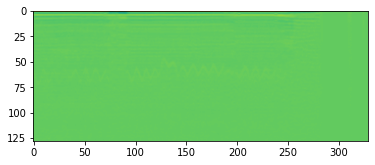

In [14]:
example = val_features[0]
plt.figure()
plt.imshow(example)


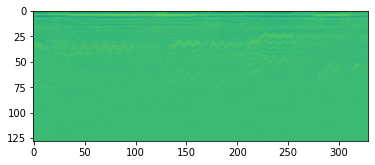

In [26]:
example2 = X_val[8]
plt.figure()
plt.imshow(example2)

# import np.

In [16]:
#normalise the dataset
X_train = np.array(train_features/(np.max(train_features)-np.min(train_features)))
X_train = X_train/np.std(X_train)

X_val = np.array(val_features/(np.max(val_features)-np.min(val_features)))
X_val = X_val/np.std(X_val)

X_test = np.array(test_features/(np.max(test_features)-np.min(test_features)))
X_test = X_test/np.std(X_test)

#turn labels(list) to arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)



In [40]:
lol = X_val[0]

In [43]:
# lol = lol[..., np.newaxis]
lol = np.expand_dims(lol, (128, 329, 3 ))
lol.shape

AxisError: ignored

# Design and test Model

In [44]:
input_shape=(128,329,1)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dense(9, activation='softmax'))

ValueError: ignored

In [33]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [34]:
history = CNNmodel.fit(X_train, train_labels, epochs=8,steps_per_epoch=3, validation_data= (X_val, val_labels))

Epoch 1/8


ValueError: ignored

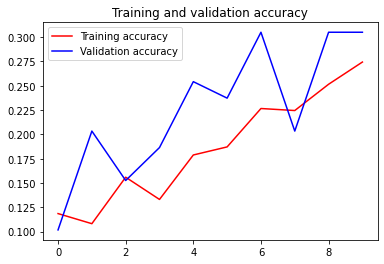

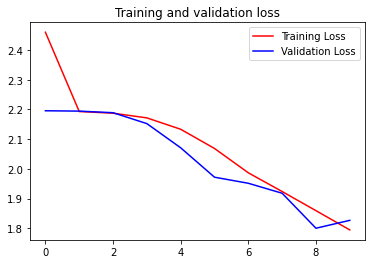

<built-in function len>


In [ ]:
def model_performance(history):

  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  pass

model_performance(history)

print(len)
